In [ ]:
import datetime, os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score


In [ ]:
# 시드 설정
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything()

In [ ]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 압축 해제 명령
!unzip -qq "/content/drive/MyDrive/chest_xray.zip" -d chest_xray

Mounted at /content/drive


In [ ]:
# 하이퍼파라미터 설정
num_classes = 2
learning_rate = 0.001
num_epochs = 50
BATCH_SIZE = 32
alpha = 0.3
patience = 10
IMG_SIZE = (224, 224)

In [ ]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 이미지넷 데이터셋의 평균과 표준편차 사용
])

In [ ]:
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/pred'
test_dir = '/content/chest_xray/test'

In [ ]:

# 데이터셋 및 데이터로더
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
# 각 클래스별 이미지 수 확인
def count_images_per_class(dataset):
    class_counts = {"NORMAL": 0, "PNEUMONIA": 0}
    for _, label in dataset:
        # label이 정수 인덱스인 경우, 클래스 이름으로 변환
        label_name = dataset.classes[label].upper()
        if label_name in class_counts:
            class_counts[label_name] += 1
        else:
            print(f"Unknown class: {label_name}")

    return class_counts

# 훈련 데이터셋에서 각 클래스별 이미지 수 확인
train_class_counts = count_images_per_class(train_dataset)
print("Training dataset class counts:")
for class_name, count in train_class_counts.items():
    print(f"  {class_name}: {count} images")

# 검증 데이터셋에서 각 클래스별 이미지 수 확인
val_class_counts = count_images_per_class(val_dataset)
print("\nValidation dataset class counts:")
for class_name, count in val_class_counts.items():
    print(f"  {class_name}: {count} images")

# 테스트 데이터셋에서 각 클래스별 이미지 수 확인
test_class_counts = count_images_per_class(test_dataset)
print("\nTest dataset class counts:")
for class_name, count in test_class_counts.items():
    print(f"  {class_name}: {count} images")

Training dataset class counts:
  NORMAL: 2574 images
  PNEUMONIA: 2994 images

Validation dataset class counts:
  NORMAL: 732 images
  PNEUMONIA: 852 images

Test dataset class counts:
  NORMAL: 364 images
  PNEUMONIA: 425 images


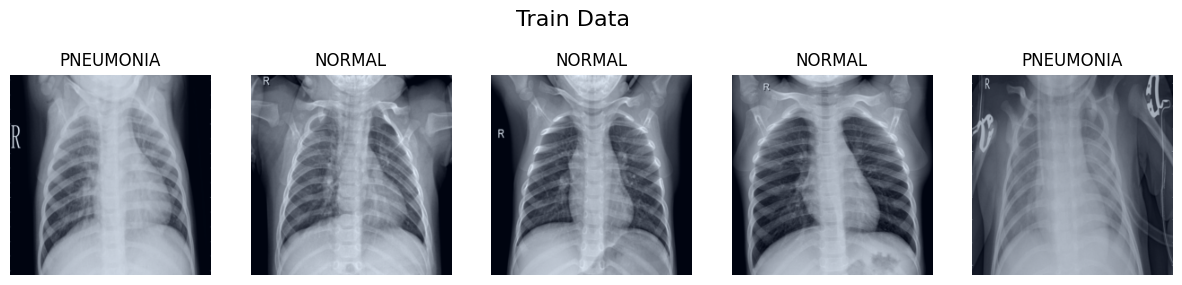

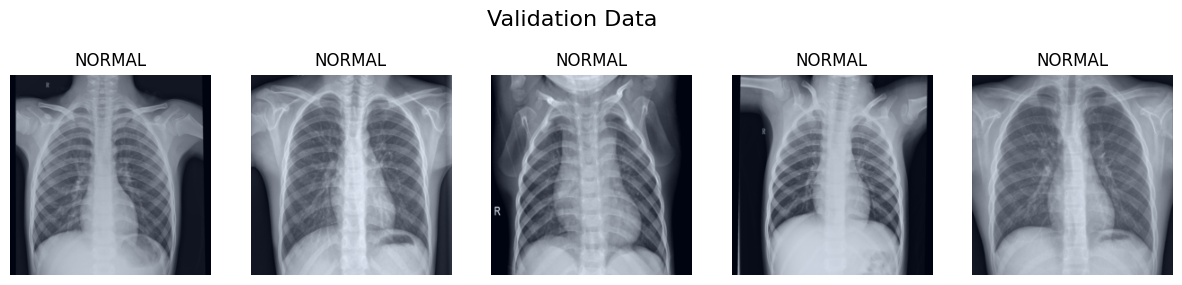

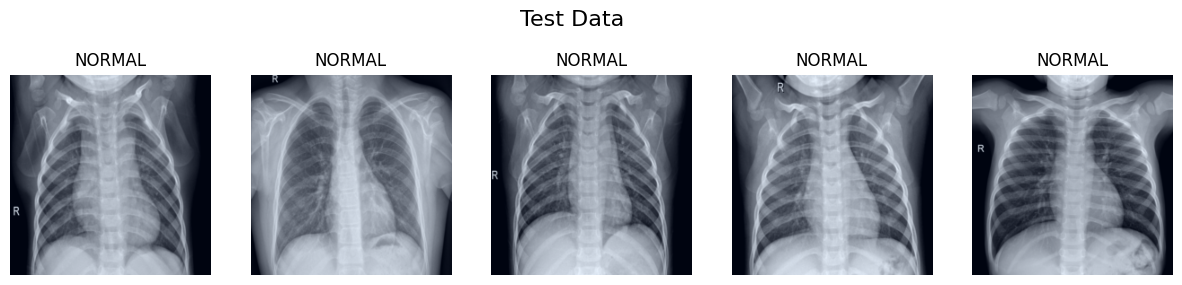

In [ ]:
def show_data(image_batch, label_batch, dataset_name):
    plt.figure(figsize=(15, 6))
    plt.suptitle(dataset_name, fontsize=16)
    for n in range(5):
        image = image_batch[n].permute(1, 2, 0).numpy()  # PyTorch의 이미지 텐서를 NumPy 배열로 변환
        label = "PNEUMONIA" if label_batch[n] else "NORMAL"
        ax = plt.subplot(2, 5, n + 1)
        ax.imshow(image)
        ax.set_title(label)
        ax.axis("off")

# 훈련 데이터 시각화
for images, labels in train_loader:
    # 이미지 정규화
    images = (images - torch.min(images)) / (torch.max(images) - torch.min(images))

    # 데이터 시각화
    show_data(images[:5], labels[:5], "Train Data")
    break

# 검증 데이터 시각화
for images, labels in val_loader:
    # 이미지 정규화
    images = (images - torch.min(images)) / (torch.max(images) - torch.min(images))

    # 데이터 시각화
    show_data(images[:5], labels[:5], "Validation Data")
    break

# 테스트 데이터 시각화
for images, labels in test_loader:
    # 이미지 정규화
    images = (images - torch.min(images)) / (torch.max(images) - torch.min(images))

    # 데이터 시각화
    show_data(images[:5], labels[:5], "Test Data")
    break

In [ ]:
class DenseNet121Binary(nn.Module):
    def __init__(self):
        super(DenseNet121Binary, self).__init__()
        # DenseNet121 모델 불러오기. 사전 훈련된 가중치 사용.
        self.features = models.densenet121(pretrained=True)

        # DenseNet121의 마지막 완전 연결 계층의 입력 크기를 가져옴.
        in_features = self.features.classifier.in_features
        self.features.classifier = nn.Linear(in_features, 2)

    def forward(self, x):
        x = self.features(x)
        return x

In [ ]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
class MixupDataLoader:
    def __init__(self, data_loader, alpha=1.0, fixed_lam=None):
        self.data_loader = data_loader
        self.alpha = alpha
        self.fixed_lam = fixed_lam

    def __iter__(self):
        for x, y in self.data_loader:
            lam = self.fixed_lam if self.fixed_lam is not None else np.random.beta(self.alpha, self.alpha)
            batch_size = x.size(0)
            index = torch.randperm(batch_size)

            mixed_x = lam * x + (1 - lam) * x[index, :]
            y_a, y_b = y, y[index]
            yield mixed_x, y_a, y_b, lam

    def __len__(self):
        return len(self.data_loader)


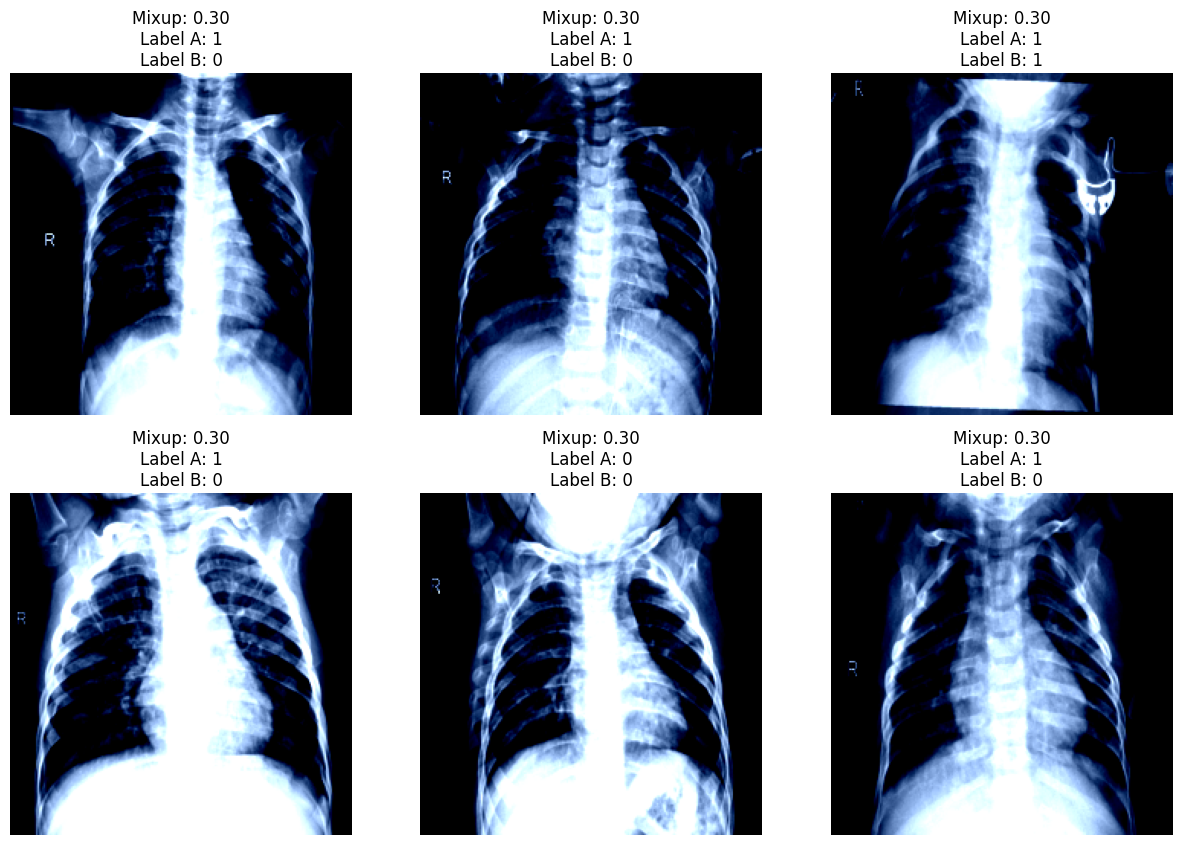

In [ ]:
def visualize_mixup_images(data_loader, num_images=6, cols=3):
    data_iter = iter(data_loader)
    mixed_x, y_a, y_b, lam = next(data_iter)

    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(15, int(15 * rows / cols)))

    mixed_x = mixed_x.cpu().numpy().transpose((0, 2, 3, 1))  # (N, C, H, W) -> (N, H, W, C)
    mixed_x = np.clip(mixed_x, 0, 1)  # 이미지 값의 범위를 [0, 1]로 클리핑

    y_a = y_a.cpu().numpy()
    y_b = y_b.cpu().numpy()

    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(mixed_x[i])
        plt.title(f'Mixup: {lam:.2f}\nLabel A: {y_a[i]}\nLabel B: {y_b[i]}')
    plt.show()

# 학습 전에 Mixup된 이미지를 시각화
fixed_lam = 0.3  # 40%:60% 비율
mixup_train_loader = MixupDataLoader(train_loader, alpha=alpha, fixed_lam=fixed_lam)
visualize_mixup_images(mixup_train_loader)

In [ ]:
# train_model_mixup 함수 정의
def train_model_mixup(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels_a, labels_b, lam in train_loader:
        inputs, labels_a, labels_b = inputs.to(device), labels_a.to(device), labels_b.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += inputs.size(0)
        correct += (lam * predicted.eq(labels_a).sum().item() + (1 - lam) * predicted.eq(labels_b).sum().item())
    train_loss = running_loss / len(train_loader.data_loader.dataset)
    train_accuracy = correct / total
    return train_loss, train_accuracy

def validate_model(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct / total
    return val_loss, val_accuracy

In [ ]:
# 모델 초기화
model = DenseNet121Binary()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# 얼리스타핑 설정
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Validation loss가 감소하면 모델을 저장합니다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=patience, verbose=True)

# 데이터 로더 정의 (MixupDataLoader는 사용자 정의 함수로 가정)
mixup_train_loader = MixupDataLoader(train_loader, alpha=alpha)

# 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 학습 및 검증 손실과 정확도를 저장할 리스트 초기화
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 에포크 반복
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_model_mixup(model, criterion, optimizer, mixup_train_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    val_loss, val_accuracy = validate_model(model, criterion, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 104MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  wa

Epoch 1/50, Train Loss: 0.3145, Train Accuracy: 0.8813, Val Loss: 0.2172, Val Accuracy: 0.9085
Validation loss decreased (inf --> 0.217159).  Saving model ...


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


Epoch 2/50, Train Loss: 0.2530, Train Accuracy: 0.9126, Val Loss: 0.1935, Val Accuracy: 0.9249
Validation loss decreased (0.217159 --> 0.193517).  Saving model ...


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


Epoch 3/50, Train Loss: 0.2492, Train Accuracy: 0.9138, Val Loss: 0.1541, Val Accuracy: 0.9501
Validation loss decreased (0.193517 --> 0.154071).  Saving model ...


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


Epoch 4/50, Train Loss: 0.2425, Train Accuracy: 0.9159, Val Loss: 0.1841, Val Accuracy: 0.9242
EarlyStopping counter: 1 out of 10


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Epoch 5/50, Train Loss: 0.2121, Train Accuracy: 0.9275, Val Loss: 0.1476, Val Accuracy: 0.9463
Validation loss decreased (0.154071 --> 0.147612).  Saving model ...


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


Epoch 6/50, Train Loss: 0.2217, Train Accuracy: 0.9227, Val Loss: 0.1439, Val Accuracy: 0.9508
Validation loss decreased (0.147612 --> 0.143902).  Saving model ...


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


Epoch 7/50, Train Loss: 0.2040, Train Accuracy: 0.9271, Val Loss: 0.1419, Val Accuracy: 0.9463
Validation loss decreased (0.143902 --> 0.141925).  Saving model ...


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Epoch 8/50, Train Loss: 0.1917, Train Accuracy: 0.9318, Val Loss: 0.1310, Val Accuracy: 0.9577
Validation loss decreased (0.141925 --> 0.130964).  Saving model ...


100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


Epoch 9/50, Train Loss: 0.2169, Train Accuracy: 0.9176, Val Loss: 0.1596, Val Accuracy: 0.9419
EarlyStopping counter: 1 out of 10


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


Epoch 10/50, Train Loss: 0.1967, Train Accuracy: 0.9320, Val Loss: 0.1619, Val Accuracy: 0.9413
EarlyStopping counter: 2 out of 10


100%|██████████| 50/50 [00:31<00:00,  1.56it/s]


Epoch 11/50, Train Loss: 0.1994, Train Accuracy: 0.9298, Val Loss: 0.1322, Val Accuracy: 0.9571
EarlyStopping counter: 3 out of 10


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Epoch 12/50, Train Loss: 0.2255, Train Accuracy: 0.9141, Val Loss: 0.1325, Val Accuracy: 0.9489
EarlyStopping counter: 4 out of 10


100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


Epoch 13/50, Train Loss: 0.1866, Train Accuracy: 0.9333, Val Loss: 0.1286, Val Accuracy: 0.9577
Validation loss decreased (0.130964 --> 0.128568).  Saving model ...


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


Epoch 14/50, Train Loss: 0.1959, Train Accuracy: 0.9331, Val Loss: 0.1386, Val Accuracy: 0.9482
EarlyStopping counter: 1 out of 10


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Epoch 15/50, Train Loss: 0.1861, Train Accuracy: 0.9287, Val Loss: 0.1300, Val Accuracy: 0.9564
EarlyStopping counter: 2 out of 10


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


Epoch 16/50, Train Loss: 0.1800, Train Accuracy: 0.9336, Val Loss: 0.1208, Val Accuracy: 0.9577
Validation loss decreased (0.128568 --> 0.120838).  Saving model ...


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


Epoch 17/50, Train Loss: 0.1806, Train Accuracy: 0.9322, Val Loss: 0.1166, Val Accuracy: 0.9583
Validation loss decreased (0.120838 --> 0.116600).  Saving model ...


100%|██████████| 50/50 [00:33<00:00,  1.47it/s]


Epoch 18/50, Train Loss: 0.1913, Train Accuracy: 0.9296, Val Loss: 0.1361, Val Accuracy: 0.9489
EarlyStopping counter: 1 out of 10


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


Epoch 19/50, Train Loss: 0.1831, Train Accuracy: 0.9338, Val Loss: 0.1259, Val Accuracy: 0.9539
EarlyStopping counter: 2 out of 10


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


Epoch 20/50, Train Loss: 0.2071, Train Accuracy: 0.9218, Val Loss: 0.1370, Val Accuracy: 0.9476
EarlyStopping counter: 3 out of 10


100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


Epoch 21/50, Train Loss: 0.1679, Train Accuracy: 0.9395, Val Loss: 0.1381, Val Accuracy: 0.9482
EarlyStopping counter: 4 out of 10


100%|██████████| 50/50 [00:33<00:00,  1.47it/s]


Epoch 22/50, Train Loss: 0.1835, Train Accuracy: 0.9323, Val Loss: 0.1311, Val Accuracy: 0.9545
EarlyStopping counter: 5 out of 10


100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


Epoch 23/50, Train Loss: 0.1828, Train Accuracy: 0.9307, Val Loss: 0.1341, Val Accuracy: 0.9508
EarlyStopping counter: 6 out of 10


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


Epoch 24/50, Train Loss: 0.1945, Train Accuracy: 0.9275, Val Loss: 0.1274, Val Accuracy: 0.9583
EarlyStopping counter: 7 out of 10


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


Epoch 25/50, Train Loss: 0.1875, Train Accuracy: 0.9294, Val Loss: 0.1154, Val Accuracy: 0.9602
Validation loss decreased (0.116600 --> 0.115352).  Saving model ...


100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


Epoch 26/50, Train Loss: 0.1832, Train Accuracy: 0.9261, Val Loss: 0.1117, Val Accuracy: 0.9596
Validation loss decreased (0.115352 --> 0.111673).  Saving model ...


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


Epoch 27/50, Train Loss: 0.1842, Train Accuracy: 0.9233, Val Loss: 0.1199, Val Accuracy: 0.9558
EarlyStopping counter: 1 out of 10


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


Epoch 28/50, Train Loss: 0.2015, Train Accuracy: 0.9189, Val Loss: 0.1120, Val Accuracy: 0.9659
EarlyStopping counter: 2 out of 10


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


Epoch 29/50, Train Loss: 0.1708, Train Accuracy: 0.9393, Val Loss: 0.1163, Val Accuracy: 0.9583
EarlyStopping counter: 3 out of 10


100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


Epoch 30/50, Train Loss: 0.1634, Train Accuracy: 0.9424, Val Loss: 0.1176, Val Accuracy: 0.9621
EarlyStopping counter: 4 out of 10


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Epoch 31/50, Train Loss: 0.1825, Train Accuracy: 0.9308, Val Loss: 0.1160, Val Accuracy: 0.9590
EarlyStopping counter: 5 out of 10


100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


Epoch 32/50, Train Loss: 0.1736, Train Accuracy: 0.9361, Val Loss: 0.1169, Val Accuracy: 0.9609
EarlyStopping counter: 6 out of 10


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


Epoch 33/50, Train Loss: 0.1779, Train Accuracy: 0.9317, Val Loss: 0.1242, Val Accuracy: 0.9564
EarlyStopping counter: 7 out of 10


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


Epoch 34/50, Train Loss: 0.2053, Train Accuracy: 0.9186, Val Loss: 0.1111, Val Accuracy: 0.9653
Validation loss decreased (0.111673 --> 0.111067).  Saving model ...


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Epoch 35/50, Train Loss: 0.1744, Train Accuracy: 0.9360, Val Loss: 0.1212, Val Accuracy: 0.9564
EarlyStopping counter: 1 out of 10


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


Epoch 36/50, Train Loss: 0.1811, Train Accuracy: 0.9295, Val Loss: 0.1135, Val Accuracy: 0.9615
EarlyStopping counter: 2 out of 10


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Epoch 37/50, Train Loss: 0.1835, Train Accuracy: 0.9282, Val Loss: 0.1215, Val Accuracy: 0.9558
EarlyStopping counter: 3 out of 10


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Epoch 38/50, Train Loss: 0.1789, Train Accuracy: 0.9296, Val Loss: 0.1205, Val Accuracy: 0.9571
EarlyStopping counter: 4 out of 10


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


Epoch 39/50, Train Loss: 0.1929, Train Accuracy: 0.9249, Val Loss: 0.1164, Val Accuracy: 0.9596
EarlyStopping counter: 5 out of 10


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Epoch 40/50, Train Loss: 0.1805, Train Accuracy: 0.9311, Val Loss: 0.1124, Val Accuracy: 0.9615
EarlyStopping counter: 6 out of 10


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


Epoch 41/50, Train Loss: 0.1869, Train Accuracy: 0.9233, Val Loss: 0.1121, Val Accuracy: 0.9609
EarlyStopping counter: 7 out of 10


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Epoch 42/50, Train Loss: 0.1709, Train Accuracy: 0.9389, Val Loss: 0.1171, Val Accuracy: 0.9577
EarlyStopping counter: 8 out of 10


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Epoch 43/50, Train Loss: 0.1753, Train Accuracy: 0.9333, Val Loss: 0.1140, Val Accuracy: 0.9596
EarlyStopping counter: 9 out of 10


100%|██████████| 50/50 [00:32<00:00,  1.56it/s]

Epoch 44/50, Train Loss: 0.1968, Train Accuracy: 0.9232, Val Loss: 0.1159, Val Accuracy: 0.9583
EarlyStopping counter: 10 out of 10
Early stopping


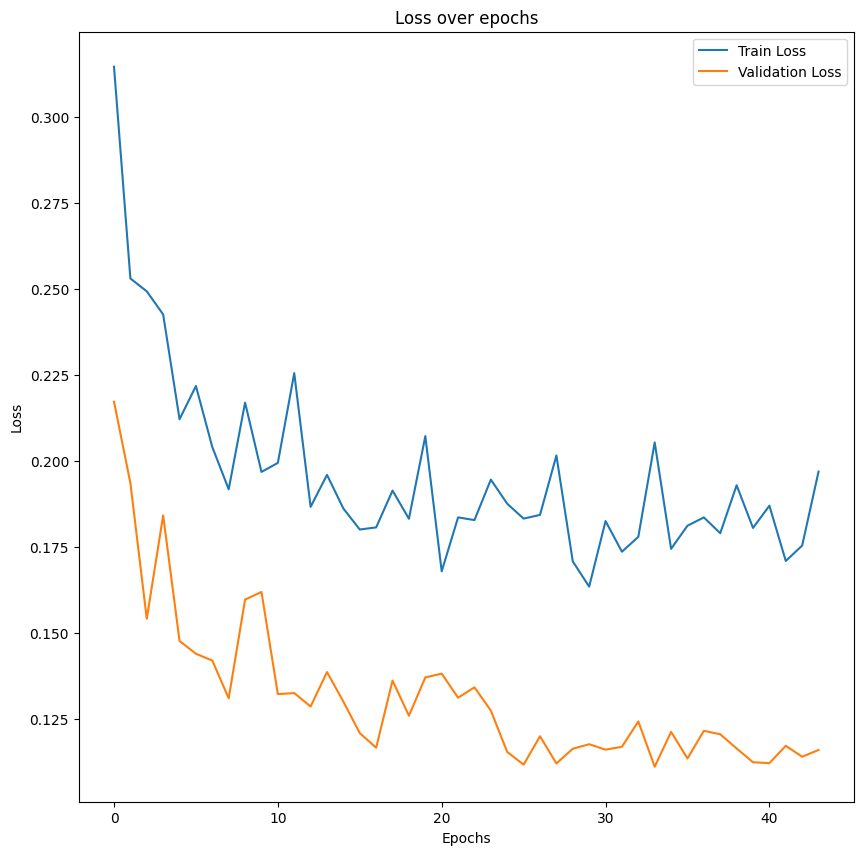

In [ ]:
# 에포크에 따른 훈련 및 검증 손실 그래프
plt.figure(figsize=(10, 10))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

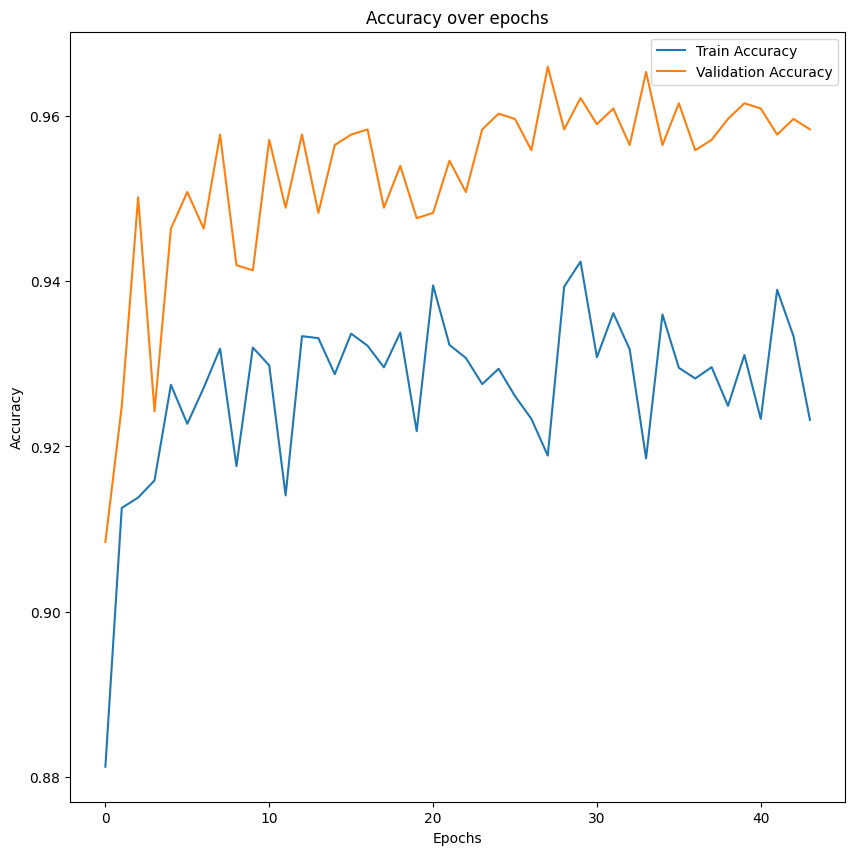

In [ ]:
# 에포크에 따른 훈련 및 검증 정확도 그래프
plt.figure(figsize=(10, 10))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# 테스트 함수 정의
def test_model(model, criterion, test_loader, device):
    model.eval()  # 모델을 평가 모드로 설정
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # 그라디언트 계산을 비활성화
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(test_loader.dataset)
    test_accuracy = correct / total
    return test_loss, test_accuracy

# 테스트 데이터셋에 대한 평가 실행
test_loss, test_accuracy = test_model(model, criterion, test_loader, device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.0647, Test Accuracy: 0.9759


In [ ]:
# 저장된 모델 로드
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

In [ ]:
def plot_confusion_matrix(cmat):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cmat, annot=True, fmt="d", cmap="Blues", xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

100%|██████████| 25/25 [00:17<00:00,  1.39it/s]


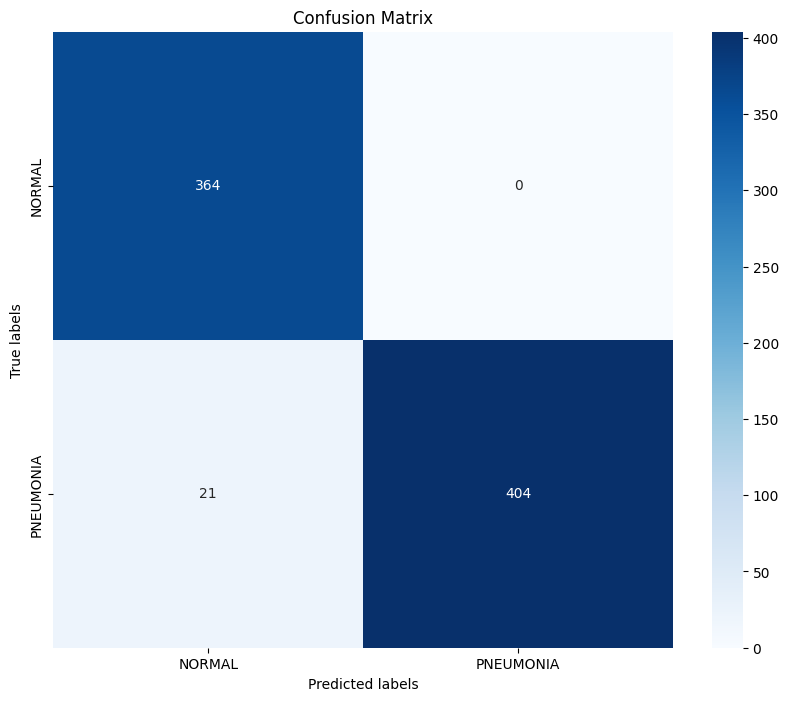

F1 Score: 0.973, Precision: 0.973, Recall: 0.975


In [ ]:
def evaluate_and_visualize(model, criterion, data_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cmat = confusion_matrix(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='macro')
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')

    plot_confusion_matrix(cmat)
    print(f'F1 Score: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}')

evaluate_and_visualize(model, criterion, test_loader, device)